In [1]:
import pandas as pd
from textblob import TextBlob
from scipy.stats import pearsonr
from pathlib import Path
import os
import sys


In [13]:
# Add scripts to path
sys.path.append(os.path.abspath(".."))
from scripts.news_utils import load_news_data, parse_dates, filter_by_ticker

# Define tickers
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META']  # Add others as needed

# Paths
news_path = '../data/raw_analyst_ratings.csv'
stock_base_path = '../data/yfinance_data'


In [14]:
# Load full news dataset once
df_news = parse_dates(load_news_data(news_path))
df_news['date'] = df_news['date'].dt.tz_localize(None)

summary_rows = []


In [15]:
for ticker in tickers:
    try:
        df_ticker_news = filter_by_ticker(
            df_news,
            "FB" if ticker == "META" else "MSF" if ticker == "MSFT" else ticker
        ).copy()
        df_ticker_news['sentiment'] = df_ticker_news['headline'].apply(lambda h: TextBlob(str(h)).sentiment.polarity)

        daily_sentiment = (
            df_ticker_news
            .groupby('date_only')['sentiment']
            .mean()
            .reset_index(name='mean_polarity')
        )
        daily_sentiment['date_only'] = pd.to_datetime(daily_sentiment['date_only'])
        daily_sentiment = daily_sentiment.set_index('date_only').sort_index()

        stock_path = f'{stock_base_path}/{ticker}_historical_data.csv'
        df_stock = pd.read_csv(stock_path)
        df_stock['Date'] = pd.to_datetime(df_stock['Date'])
        df_stock = df_stock.set_index('Date').sort_index()

        earliest_news_date = df_ticker_news['date'].min().normalize()
        df_stock = df_stock[df_stock.index >= earliest_news_date]
        df_stock['Daily_Return'] = df_stock['Close'].pct_change() * 100

        df_merged = (
            df_stock[['Daily_Return']]
            .join(daily_sentiment.rename(columns={'mean_polarity': 'sentiment'}), how='inner')
            .dropna()
        )

        if len(df_merged) > 1:
            corr, p_val = pearsonr(df_merged['sentiment'], df_merged['Daily_Return'])
            mean_sent = df_merged['sentiment'].mean()
            std_return = df_merged['Daily_Return'].std()
            n = len(df_merged)
            summary_rows.append({
                'Ticker': ticker,
                'Correlation': corr,
                'p-value': p_val,
                'N_days': n,
                'Mean_Sentiment': mean_sent,
                'Std_Return': std_return
            })
        else:
            print(f"[!] Skipping {ticker}: insufficient data")

    except Exception as e:
        print(f"[!] Error processing {ticker}: {e}")


In [16]:
# Final summary table
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values('Correlation', ascending=False)
print("\n=== Summary Correlation Table ===")
print(summary_df)



=== Summary Correlation Table ===
  Ticker  Correlation   p-value  N_days  Mean_Sentiment  Std_Return
6   META     0.294937  0.011307      73        0.040328    3.910288
0   AAPL     0.107867  0.412012      60        0.044788    3.964989
5   NVDA     0.104241  0.000464    1124        0.073099    3.272411
4   TSLA     0.082518  0.213497     229        0.055281    5.014665
2   GOOG     0.056656  0.289825     351        0.041882    2.150933
3   AMZN    -0.002240  0.991152      27        0.023250    2.198021
1   MSFT    -0.182702  0.590787      11        0.155372    1.063285


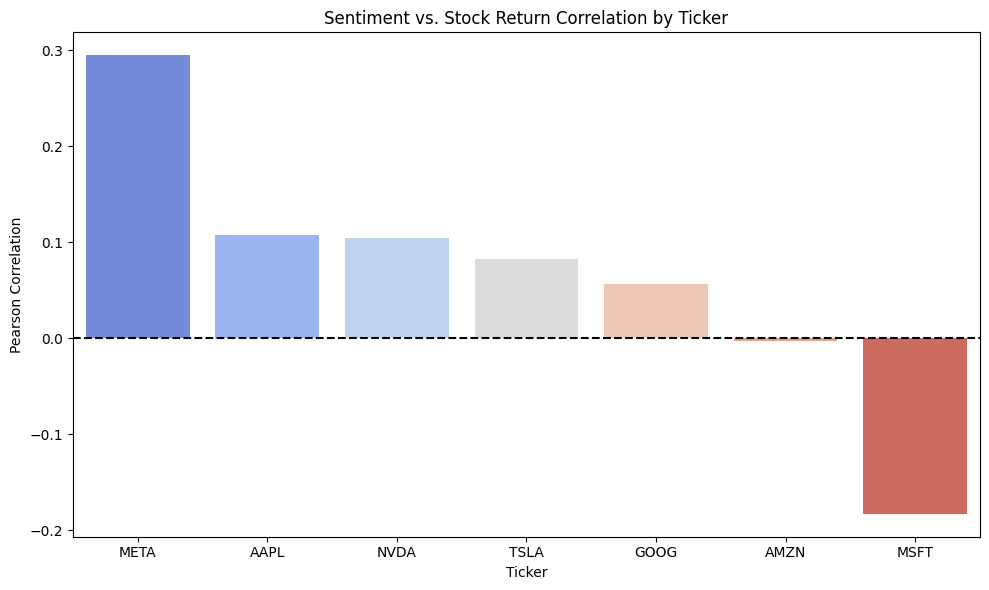

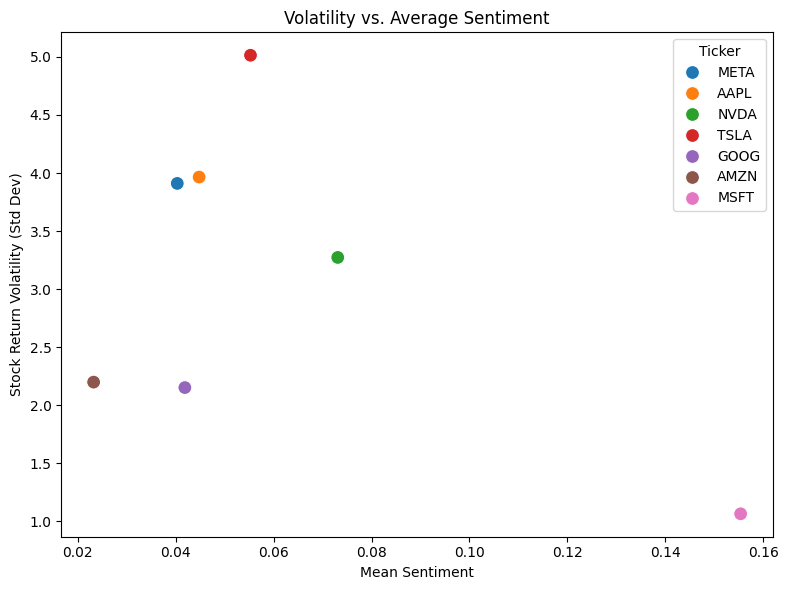

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Barplot of Correlation Coefficients
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='Ticker', y='Correlation', hue='Ticker', palette='coolwarm', legend=False)
plt.axhline(0, color='black', linestyle='--')
plt.title('Sentiment vs. Stock Return Correlation by Ticker')
plt.ylabel('Pearson Correlation')
plt.xlabel('Ticker')
plt.tight_layout()
plt.show()

# Scatterplot of Mean Sentiment vs Std Return
plt.figure(figsize=(8, 6))
sns.scatterplot(data=summary_df, x='Mean_Sentiment', y='Std_Return', hue='Ticker', s=100)
plt.title('Volatility vs. Average Sentiment')
plt.xlabel('Mean Sentiment')
plt.ylabel('Stock Return Volatility (Std Dev)')
plt.tight_layout()
plt.show()
